In [ ]:
import os
import warnings
import argparse

import scanpy as sc
import anndata
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

import Riff

os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")

# 1. Set Parameters

In [3]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=0)
parser.add_argument("--device", type=int, default=4)
parser.add_argument("--warmup_steps", type=int, default=-1)
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--weight_decay", type=float, default=2e-4, help="weight decay")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--lr_f", type=float, default=0.01, help="learning rate for evaluation")
parser.add_argument("--weight_decay_f", type=float, default=1e-4, help="weight decay for evaluation")
parser.add_argument("--linear_prob", action="store_true", default=True)
parser.add_argument("--load_model", action="store_true")
parser.add_argument("--save_model", action="store_true")
parser.add_argument("--use_cfg", action="store_true")
parser.add_argument("--logging", action="store_true")
parser.add_argument("--scheduler", action="store_true", default=True)

# for graph classification
parser.add_argument("--pooling", type=str, default="mean")
parser.add_argument("--deg4feat", action="store_true", default=False, help="use node degree as input feature")
parser.add_argument("--batch_size", type=int, default=32)

# adjustable parameters
parser.add_argument("--encoder", type=str, default="gat")
parser.add_argument("--decoder", type=str, default="gat")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--max_epoch", type=int, default=50000, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--alpha_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")
parser.add_argument("--beta_l", type=float, default=1, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.3)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm")

# RIF parameter
parser.add_argument("--batch_node", type=int, default=4096)
parser.add_argument("--num_neighbors", type=int, default=15)
parser.add_argument("--num_features", type=int, default=3000)
parser.add_argument("--ref_name", type=list, default=["MouseOlfactoryBulb"])
parser.add_argument("--target_name", type=str, default="151507")
parser.add_argument("--cluster_label", type=str, default= "combined_refine")
parser.add_argument("--folder_name", type=str, default="/home/wcy/code/datasets/SlideseqV2/")  
parser.add_argument("--num_classes", type=int, default=7, help = "The number of clusters")
parser.add_argument("--radius", type=int, default=7)

# read parameters
args = parser.parse_args(args=['--target_name', 'Puck_200127_15',
                              '--ref_name', ['MouseOlfactoryBulb']]) 
args

Namespace(activation='elu', alpha_l=2, attn_drop=0.1, batch_node=4096, batch_size=32, beta_l=1, cluster_label='combined_refine', decoder='gat', deg4feat=False, device=4, drop_edge_rate=0.0, encoder='gat', folder_name='/home/wcy/code/datasets/SlideseqV2/', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='weighted_mse', lr=0.001, lr_f=0.01, mask_gene_rate=0.3, max_epoch=50000, negative_slope=0.2, norm='batchnorm', num_classes=7, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=15, num_out_heads=1, optimizer='adam', pooling='mean', radius=7, ref_name=['MouseOlfactoryBulb'], remask_rate=0.0, replace_rate=0.05, residual=False, save_model=False, scheduler=True, seeds=0, target_name='Puck_200127_15', use_cfg=False, warm_up=50, warmup_steps=-1, weight_decay=0.0002, weight_decay_f=0.0001)

# 2. Preprocession

In [5]:
adata_ref_list = []
for ref_name in args.ref_name:
    adata_ref = sc.read_h5ad('/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output/adata/MouseOlfactoryBulb.h5ad')
    pred = adata_ref.obs['combined_refine']
    adata_ref = Riff.read_h5ad('/home/wcy/code/datasets/Stereo-seq/MouseOlfactoryBulb')
    adata_ref.obs['combined_refine'] = pred

    num_classes = adata_ref.obs[args.cluster_label].nunique()
    adata_ref.obs[args.cluster_label] = adata_ref.obs[args.cluster_label].astype('category')
    adata_ref_list.append(adata_ref)

data_path = os.path.join(args.folder_name, args.target_name)
adata_target = Riff.read_h5ad(data_path)
        
adata_ref_list, adata_target, graph_ref_list, graph_target = Riff.transfer_preprocess(args, adata_ref_list, adata_target)

=============== Contructing graph =================


# 3. Training and spatial domain identification

In [10]:
adata_ref, adata_target = Riff.transfer_train(args, adata_ref_list, graph_ref_list, adata_target, graph_target, num_classes)

=============== Building model ===============
===================== Start training =======================


# Epoch 49999: train_loss: 0.63, recon_loss: 4.70, cls_loss: 0.59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [3:07:17<00:00,  4.45it/s]


NameError: name 'map_dict' is not defined

(-5108.555, -588.545, -5670.73, -847.6700000000001)

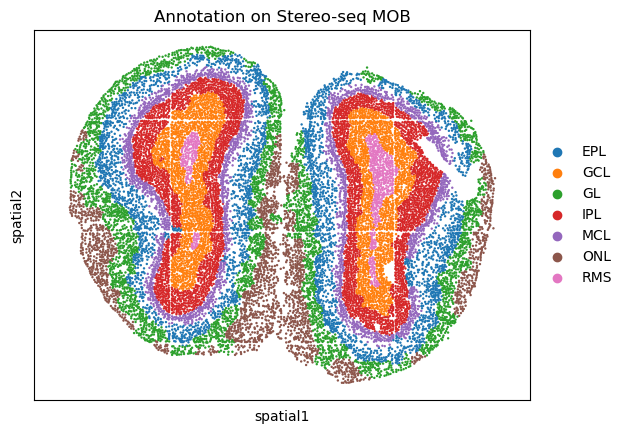

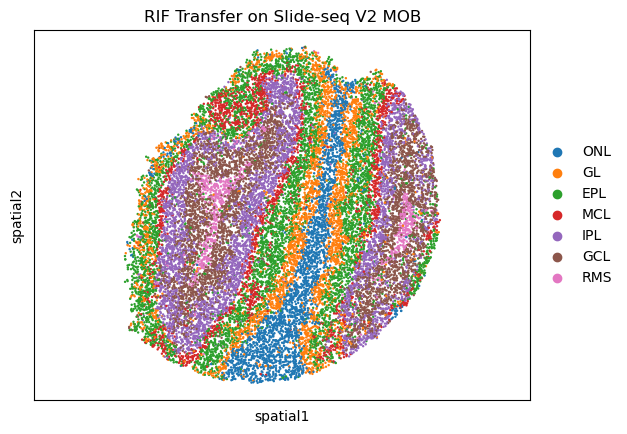

In [47]:
map_dict = {0:'ONL', 1:'GL', 2:'EPL', 3:'MCL', 4:'IPL', 5:'GCL', 6:'RMS'}
adata_target.obs['cluster_pred'] = adata_target.obs['cluster_pred'].astype(int).astype('category')
adata_target.obs['name'] = adata_target.obs['cluster_pred'].map(map_dict).values
adata_target.obs['name'] = adata_target.obs['name'].astype('category')

adata_ref[0].obs['label'] = graph_ref_list[0].ndata['label']
adata_ref[0].obs['label'] = adata_ref[0].obs['label'].astype(int).astype('category')
adata_ref[0].obs['name'] = adata_ref[0].obs['label'].astype(int).map(map_dict).values
adata_ref[0].obs['name'] = adata_ref[0].obs['name'].astype('category')

spatial = adata_ref_list[0].obsm['spatial'].copy()
adata_ref_list[0].obsm['spatial'] = np.stack([spatial[:,1], spatial[:,0]], axis=1)
sc.pl.embedding(adata_ref_list[0], basis='spatial', color=['name'], title=['Annotation on Stereo-seq MOB'], s=12, show=False)
plt.axis('equal')
adata_target.obsm['spatial'] = (-1)*adata_target.obsm['spatial']
sc.pl.embedding(adata_target, basis='spatial', color=['name'], title=['RIF Transfer on Slide-seq V2 MOB'], s=12, show=False)
plt.axis('equal')

# 4. Batch effect removal

In [41]:
adata_ref[0] = adata_ref[0][:, adata_target.var_names]
adata_ref[0]

View of AnnData object with n_obs × n_vars = 19109 × 3000
    obs: 'imagerow', 'imagecol', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'combined_refine', 'cluster_pred', 'name', 'label'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'combined_refine_colors', 'cluster_pred_colors', 'name_colors', 'label_colors'
    obsm: 'spatial', 'Riff_embedding', 'Riff_imputed'

In [43]:
X = np.vstack([adata_ref[0].X, adata_target.X])
embedding = np.vstack([adata_ref[0].obsm['Riff_embedding'], adata_target.obsm['Riff_embedding']])
batch = np.array(['Stereoseq']*adata_ref[0].n_obs + ['SlideseqV2']*adata_target.n_obs)
label = np.array(list(adata_ref[0].obs['name'].values)+list(adata_target.obs['name'].values))

adata_combine = anndata.AnnData(X=X)
adata_combine.obs['batch'] = batch
adata_combine.obs['name'] = label
adata_combine.obsm['embedding'] = embedding
adata_combine

AnnData object with n_obs × n_vars = 39248 × 3000
    obs: 'batch', 'name'
    obsm: 'embedding'

[<AxesSubplot: title={'center': 'Batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'cluster'}, xlabel='UMAP1', ylabel='UMAP2'>]

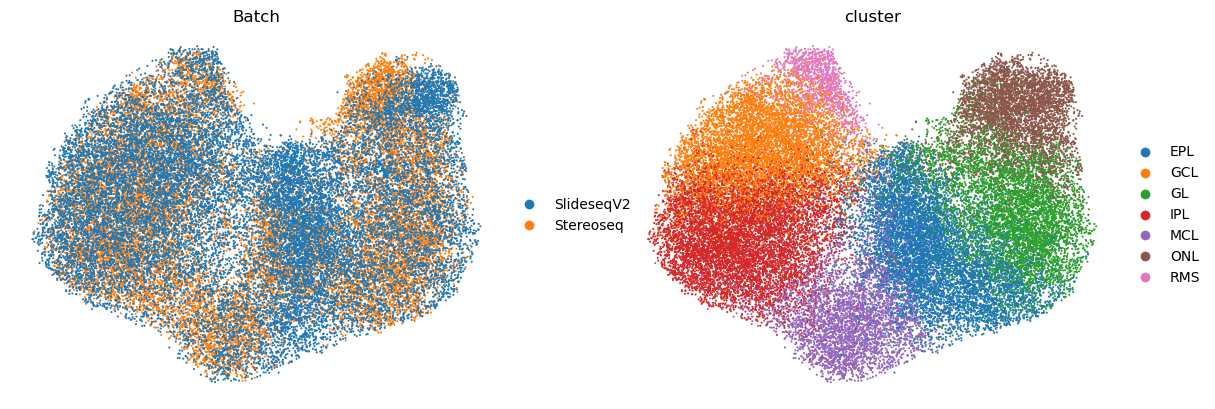

In [45]:
sc.pp.neighbors(adata_combine, use_rep='embedding')
sc.tl.umap(adata_combine)
sc.pl.umap(adata_combine, color=['batch', 'name'], title=['Batch', 'cluster'], s=9, frameon=False, show=False)